In [1]:
correct_cwd = False

In [2]:
import os
if correct_cwd == False:
    os.chdir("..")
    correct_cwd = True

# Toy density estimation

In [3]:
import nux
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit, vmap
import nux.networks as net
import optax
import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

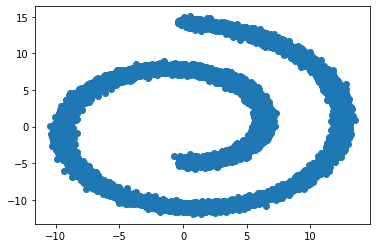

In [4]:
data = make_swiss_roll(n_samples=20000, noise=0.3, random_state=0)[0][:,[0,2]]
data = jnp.array(data)
key = random.PRNGKey(0)
data = random.permutation(key, data)
plt.scatter(*data.T)

# The flow will use dense and logistic mixture cdf layers

In [5]:
# Specify what the conditioner neural network should look like for the coupling layers
def create_network(out_shape):
    return net.MLP(out_dim=out_shape[-1],
                   layer_sizes=[32]*2,
                   nonlinearity="relu",
                   parameter_norm=None,
                   dropout_rate=None)

# Function to create the normalizing flow
def create_flow():
    return nux.sequential(nux.AffineLDU(),
                          nux.CouplingLogisticMixtureLogit(n_components=8, create_network=create_network),
                          nux.AffineLDU(),
                          nux.CouplingLogisticMixtureLogit(n_components=8, create_network=create_network),
                          nux.AffineLDU(),
                          nux.UnitGaussianPrior())

# Initialize the flow with a batch of data

In [6]:
key = random.PRNGKey(0)
inputs = {"x": data[:128]}
flow = nux.Flow(create_flow, key, inputs, batch_axes=(0,))

# Train using the MaximumLikelihoodTrainer class

In [7]:
trainer = nux.MaximumLikelihoodTrainer(flow, lr=1e-3, warmup=None)

/home/eddie/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


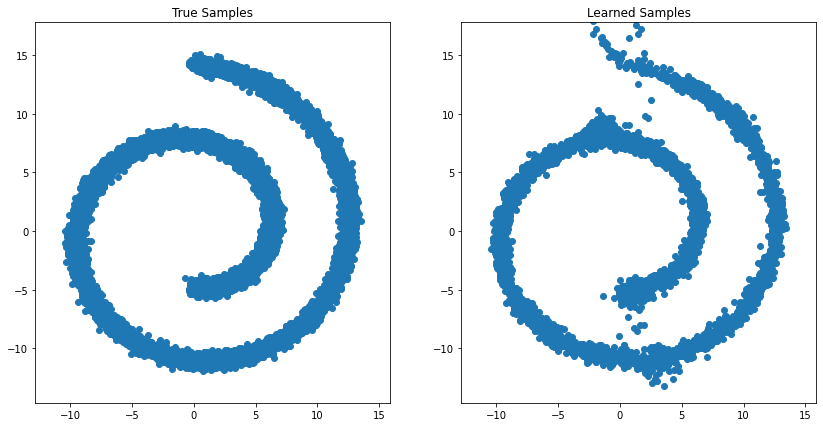

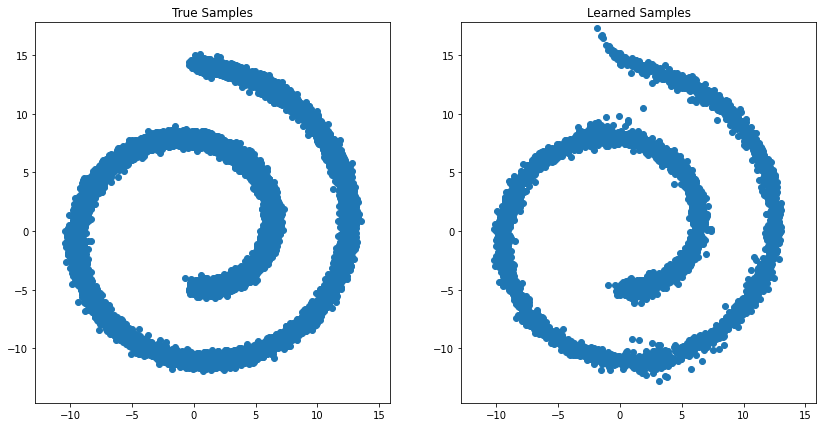

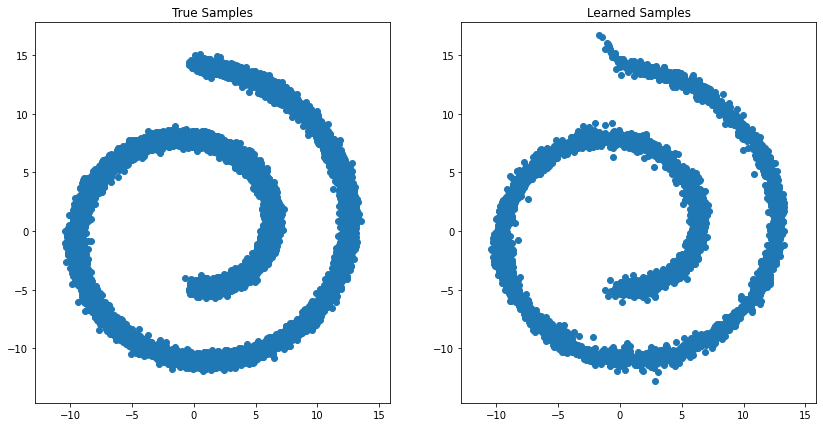

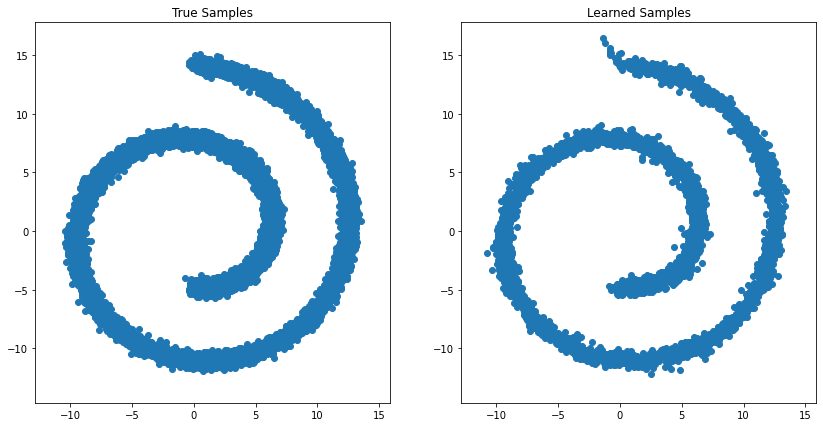

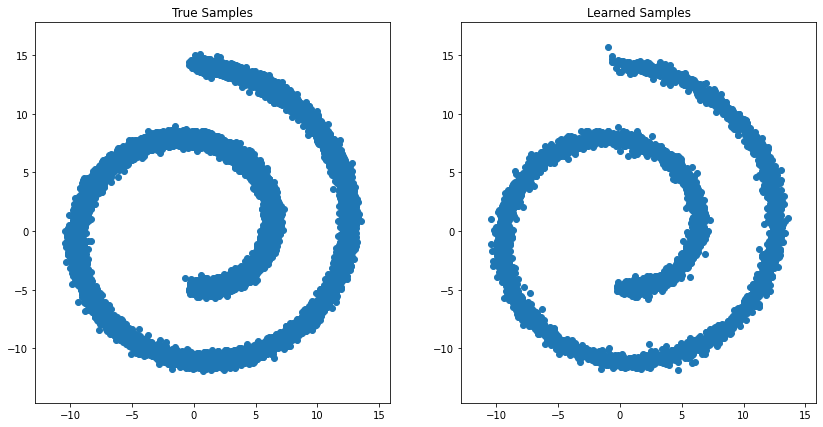

In [8]:
# This loop takes 30 seconds to get a nll of 4.70 using 1 GPU
batch_size = 128
n_batches = 2000
n_iters = 5

key = random.PRNGKey(0)
keys = random.split(key, n_iters)
pbar = tqdm.tqdm_notebook(list(enumerate(keys)))
for i, key in pbar:
    # Take a doubly-batched minibatch to feed into the scan trainer
    batch_idx = random.randint(key, minval=0, maxval=data.shape[0], shape=(n_batches, batch_size))
    input_batch = {"x": data[batch_idx]}
    
    # Compute 'n_batches' number of gradient steps in a really fast lax.scan loop
    losses = trainer.grad_step_scan_loop(key, input_batch)
    pbar.set_description(f"nll: {losses.mean():.2f}")
    
    # Sample from the trained flow
    samples = trainer.flow.sample(key, n_samples=5000)

    # Plot the samples against the true samples
    (xmin, ymin), (xmax, ymax) = data.min(axis=0), data.max(axis=0)
    xspread, yspread = xmax - xmin, ymax - ymin
    xmin -= 0.1*xspread
    xmax += 0.1*xspread
    ymin -= 0.1*yspread
    ymax += 0.1*yspread

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.scatter(*data.T); ax1.set_title("True Samples")
    ax2.scatter(*samples["x"].T); ax2.set_title("Learned Samples")
    ax1.set_xlim(xmin, xmax); ax1.set_ylim(ymin, ymax)
    ax2.set_xlim(xmin, xmax); ax2.set_ylim(ymin, ymax)
    plt.show()